In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

Dependencias a instalar

In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.2.0


**El set de Datos de MPG**
el set de datos esta disponible de el siguiente repositorio UCI Machine Learning Repository.

Obtenga la data
Primero descargue el set de datos.

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 4us/step


'/root/.keras/datasets/auto-mpg.data'

Importelo usando pandas.

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


Limpie la data
El set de datos contiene algunos valores desconocidos.

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Para Mantener este tutorial inicial sencillo eliminemos las siguientes filas.

In [6]:
dataset = dataset.dropna()

La columna de "Origin" realmente es categorica, no numerica. Entonces conviertala a un "one-hot":

In [7]:
origin = dataset.pop('Origin')

In [8]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


Dividamos la data en entrenamiento y prueba
Ahora divida el set de datos en un set de entrenamiento y otro de pruebas.

Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

In [9]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Inspeccione la data
Revise rapidamente la distribucion conjunta de un par de columnas de el set de entrenamiento.

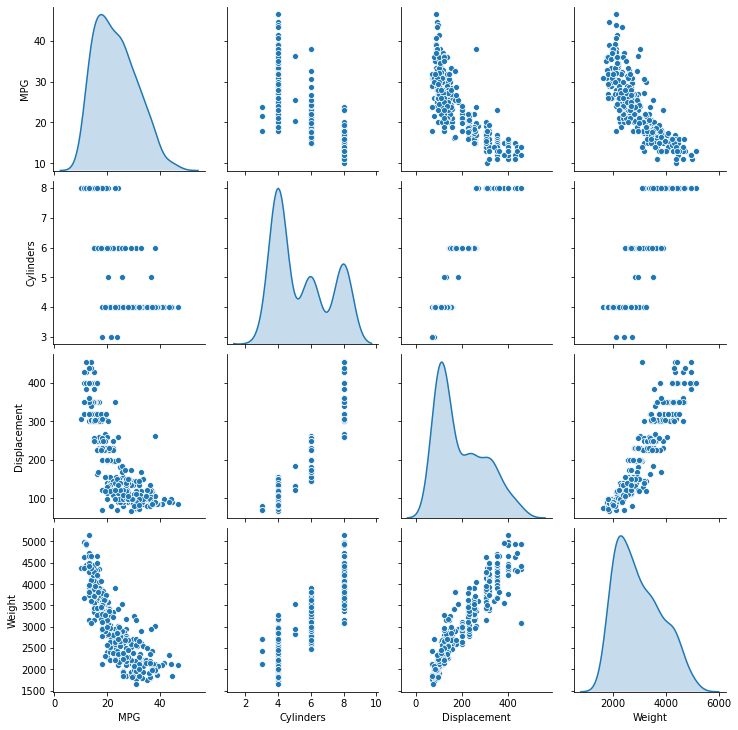

In [10]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Tambien revise las estadisticas generales:

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


Separe las caracteristicas de las etiquetas.
Separe el valor objetivo, o la "etiqueta" de las caracteristicas. Esta etiqueta es el valor que entrenara el modelo para predecir.

In [12]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

Normalice la data
Revise otra vez el bloque de train_stats que se presento antes y note la diferencia de rangos de cada caracteristica.

Es una buena práctica normalizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo * podría * converger sin normalización de características, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

Nota: Aunque generamos intencionalmente estas estadísticas solo del conjunto de datos de entrenamiento, estas estadísticas también se utilizarán para normalizar el conjunto de datos de prueba. Necesitamos hacer eso para proyectar el conjunto de datos de prueba en la misma distribución en la que el modelo ha sido entrenado.

In [13]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Estos datos normalizados es lo que usaremos para entrenar el modelo.

Precaución: las estadísticas utilizadas para normalizar las entradas aquí (media y desviación estándar) deben aplicarse a cualquier otro dato que se alimente al modelo, junto con la codificación de un punto que hicimos anteriormente. Eso incluye el conjunto de pruebas, así como los datos en vivo cuando el modelo se usa en producción.

El modelo
Construye el modelo
Construyamos nuestro modelo. Aquí, utilizaremos un modelo secuencial con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo. Los pasos de construcción del modelo se envuelven en una función, build_model, ya que crearemos un segundo modelo, más adelante.

In [14]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [15]:
model = build_model()

Inspeccione el modelo
Use el método .summary para imprimir una descripción simple del modelo

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Ahora pruebe el modelo. Tome un lote de ejemplos 10 de los datos de entrenamiento y llame amodel.predict en él.

In [17]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.21410947],
       [-0.04358136],
       [ 0.02141678],
       [ 0.18230556],
       [-0.05936465],
       [ 0.01640818],
       [-0.0875389 ],
       [ 0.501278  ],
       [-0.03847629],
       [-0.44443852]], dtype=float32)

Parece estar funcionando, y produce un resultado de la forma y tipo esperados.

Entrenar a la modelo
Entrene el modelo durante 1000 épocas y registre la precisión de entrenamiento y validación en el objeto history.

In [18]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto history.

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,3.343173,1.146180,3.343173,10.351773,2.440444,10.351773,995
996,3.306913,1.178836,3.306913,9.856860,2.420045,9.856860,996
997,3.189339,1.155625,3.189339,10.119001,2.483624,10.119001,997
998,3.272781,1.190896,3.272781,9.865754,2.408396,9.865754,998
999,3.187409,1.132646,3.187409,10.167198,2.460398,10.167198,999


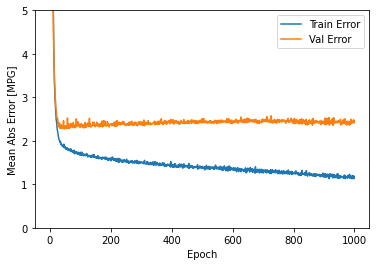

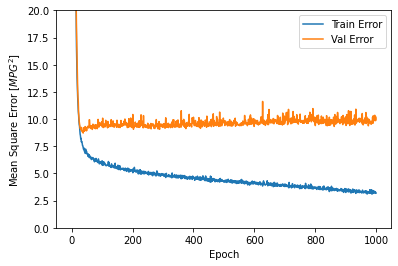

In [20]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

Este gráfico muestra poca mejora, o incluso degradación en el error de validación después de aproximadamente 100 épocas. Actualicemos la llamada model.fit para detener automáticamente el entrenamiento cuando el puntaje de validación no mejore. Utilizaremos una * devolución de llamada de EarlyStopping * que pruebe una condición de entrenamiento para cada época. Si transcurre una cantidad determinada de épocas sin mostrar mejoría, entonces detiene automáticamente el entrenamiento.

Puedes obtener más información sobre esta devolución de llamada Aca.


..............................................

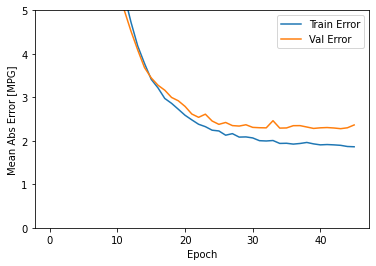

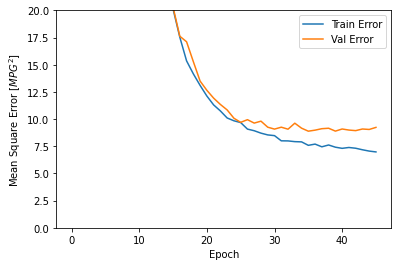

In [21]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

El gráfico muestra que en el conjunto de validación, el error promedio generalmente es de alrededor de +/- 2 MPG. ¿Es esto bueno? Le dejaremos esa decisión a usted.

Veamos qué tan bien generaliza el modelo al usar el conjunto ** test **, que no usamos al entrenar el modelo. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real.

In [22]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.0374 - mae: 1.8207 - mse: 6.0374
Testing set Mean Abs Error:  1.82 MPG


Haga Predicciones
Finalmente, prediga los valores de MPG utilizando datos en el conjunto de pruebas:

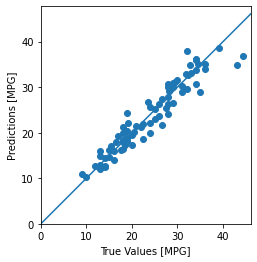

In [23]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

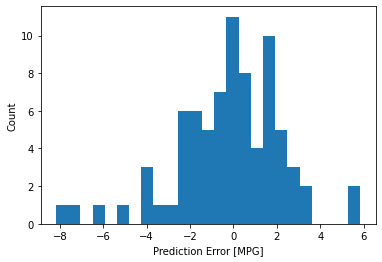

In [24]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

Conclusion
Este cuaderno introdujo algunas técnicas para manejar un problema de regresión.

El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión (se utilizan diferentes funciones de pérdida para problemas de clasificación).
Del mismo modo, las métricas de evaluación utilizadas para la regresión difieren de la clasificación. Una métrica de regresión común es el error absoluto medio (MAE).
Cuando las características de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.
Si no hay muchos datos de entrenamiento, una técnica es preferir una red pequeña con pocas capas ocultas para evitar el sobreajuste.
La detención temprana es una técnica útil para evitar el sobreajuste.

In [25]:
!ls -a

.  ..  .config	sample_data


In [27]:
!ifconfig 

/bin/bash: ifconfig: command not found
